# Лабораторная работа № 4.1
## "Определение энергии $\alpha$-частиц по величине их пробега в воздухе"

Измеряется пробег $\alpha$-частиц в воздухе двумя способами $-$ с помощью торцевого счетчика Гейгера и сцинтилляционного счетчика, $-$ и по полученным величинам определяется их энергия.

In [1]:
WORKING_DIRECTORY = 'ildar'
RA_FILE = 'radium.csv'
U_FILE = 'uran.csv'
PU_FILE = 'pu.csv'
AM_TH_FILE = 'Am_Th.csv'
# TODO: поменяйте на свой
HEADER_NUMBER = 21

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

In [3]:
def read_table_and_time(path):
    df = pd.read_csv(
        path, 
        delimiter=';')
    # Найдем время
    MAGIC_WORD = 'ROOT:'
    time = df[df[MAGIC_WORD] == 'LTime'].iloc[-1, 1]
    # Возьмем нужные данные
    ind = df[df[MAGIC_WORD] == 'Channel'].index[0]
    df.columns = df.iloc[ind]
    df = df.iloc[ind+1:]
    # Обнулим индексы
    df.reset_index(drop=True, inplace=True)
    # Приведем к численному типу
    df = df.apply(pd.to_numeric)
    return df, float(time)

In [4]:
def plot_data_optimized(x_values, y_values, fig=None, axes=None,
                        title=r'Graph', x_label=r'X', y_label=r'Y', 
                        save_to=False, threshold=0.0):
    '''
    Умное построение:
    1) Убираются данные, похожие на шум (те, чье значение < 1% от максимального)
    '''
    if fig is None or axes is None:
        fig, axes = plt.subplots(figsize=(16, 9))
    
    max_y, min_y = np.max(y_values), np.min(y_values)
    threshold *= (max_y-min_y)
    # Перед тем, как менять данные, сделаем их копию
    x_values, y_values = x_values.copy(), y_values.copy()
    x_values, y_values = (x_values[y_values >= threshold], 
                          y_values[y_values >= threshold])
    
    axes.plot(x_values, y_values)
    axes.grid(True)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)
    
    # Сохраним
    if save_to:
        fig.savefig(save_to)
    return fig, axes

In [5]:
from scipy.optimize import curve_fit
def fit_with_gauss(x_data, y_data, y_error=None, initial_guess=[1, 1, 1]):
    #def find_optimal_function(data, functions, y_data='N', x_data='LL', y_error=None):
    if y_error is None:
        #y_error = y_data + '_error'
        y_error = np.zeros(len(y_data))
    #  Подготим все к подгону! 1) Вычтем минимальное значение;
    # 2) поделим X на максимальный из X;
    y_data = y_data.copy()
    x_data = x_data.copy()
    min_y = np.min(y_data)
    y_data -= min_y
    max_x = np.max(x_data)
    x_data /= max_x
    func = lambda x, a, mu, sigma: a*np.exp(-(x-mu)**2/(2*sigma**2))
    popt, pcov = curve_fit(func, x_data, y_data, maxfev=100000, p0=initial_guess)
    # Преобразуем оптимальные параметры обратно
    popt[1] *= max_x
    popt[2] *= max_x
    return lambda x: (func(x , *popt) + min_y), popt

In [6]:
def get_gauss_halfwidth(sigma):
    return abs(2*np.sqrt(2*np.log(2))*sigma)

### Градуировка по $_{\,\,88}^{226}Ra$

In [7]:
# Перед началом работы создадим таблицу, которую просят сделать в доп. описании
res_table_cols = [r'Источник', r'N_i', r'Delta N_i', r'E_i', r'Delta E_i', r'R_i']
result_table = pd.DataFrame(columns=res_table_cols)

In [8]:
ra_df, ra_time = read_table_and_time(os.path.join(WORKING_DIRECTORY, 
                                                  RA_FILE))
ra_df.head()

19,Channel,Value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [9]:
x_data = ra_df['Channel']
y_data = ra_df['Value']

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


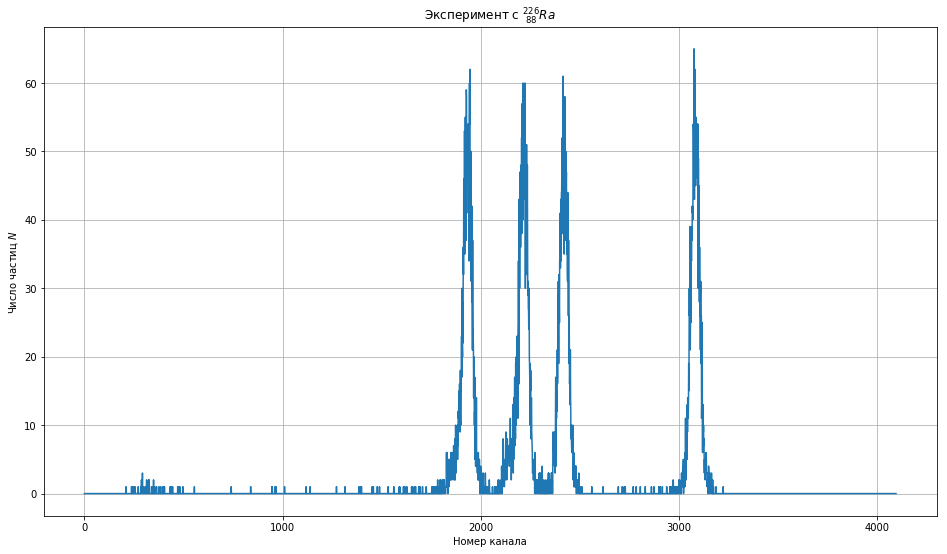

In [10]:
plot_data_optimized(x_values=x_data, y_values=y_data,
                    title=r'Эксперимент с $^{226}_{\,\,88}Ra$', 
                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                    save_to='out1.pdf')[0].show()

Попытаемся аппросимировать пики гауссианой

In [11]:
# TODO: замените на свои
# Я очень хорошо угадал свои интервалы!
peaks = [
    # Мелкий пик
    #(2200, 2290),
    # Большой пик
    (1750, 2050),
    # Мелкий пик
    #(2550, 2630),
    # Большой пик
    (2150, 2300),
    # Большой пик
    (2350, 2500),
    # Большой пик
    (3000, 3150)
]

In [12]:
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

In [13]:
f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


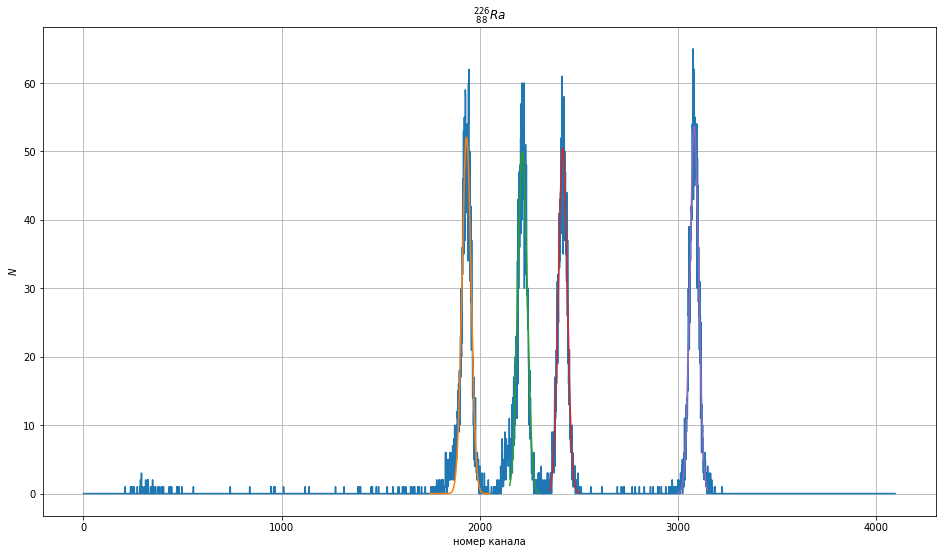

In [14]:
fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'$^{226}_{\,\,88}Ra$', 
                                    x_label=r'номер канала', y_label=r'$N$',
                                    save_to='out1.pdf')
    # Заполним таблицу из лабника
    
    result_table = pd.concat(
        [result_table, pd.DataFrame([['Ra', 
                                      params[i][1], 
                                      get_gauss_halfwidth(params[i][2]), 
                                      # Пока мы их не знаем
                                      0, 0, 0]], columns=res_table_cols)])
fig.show()

In [15]:
result_table

,Источник,N_i,Delta N_i,E_i,Delta E_i,R_i
0,Ra,1932.988894,53.403646,0,0,0
0,Ra,2215.260825,55.432073,0,0,0
0,Ra,2418.818956,52.437278,0,0,0
0,Ra,3082.156351,51.648898,0,0,0


Имеем хорошие пики! Теперь пора на них садиться...

In [16]:
# Вытащим матожидания
mu = [param[1] for param in params]

Энергии даны в лабнике $E_1$ = {{E = []; E.append(4.784); E[0]}} МэВ, $E_2$ = {{E.append(5.490); format(E[1], '.3f')}} МэВ, $E_3$ = {{E.append(6.002); E[2]}} МэВ, $E_4$ = {{E.append(7.687); E[3]}} МэВ.

Построим по ним линейную регрессию и убедимся, что действительно существует линейная зависимость между $E$ и номером канала. \label{p1:linreg}

p-value: 1.000000


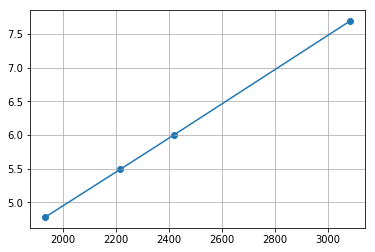

In [17]:
from scipy.stats import chi2_contingency
print('p-value: %f' % chi2_contingency(mu, E)[1])
plt.scatter(mu, E)
plt.plot(mu, E)
plt.grid()
plt.show()

Видим, что прибор был действительно настроен хорошо.

Теперь мы готовы анализировать дальнейшие спектры, но для начала подсчитаем коэффициент линейной регрессии:

In [18]:
from scipy.stats import linregress
k = linregress(mu, E).slope

<center> k = {{format(k, '.8f')}} </center>

Теперь построим графики $N(E)$, где $E$ пересчитаем по найденному выше $k$

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


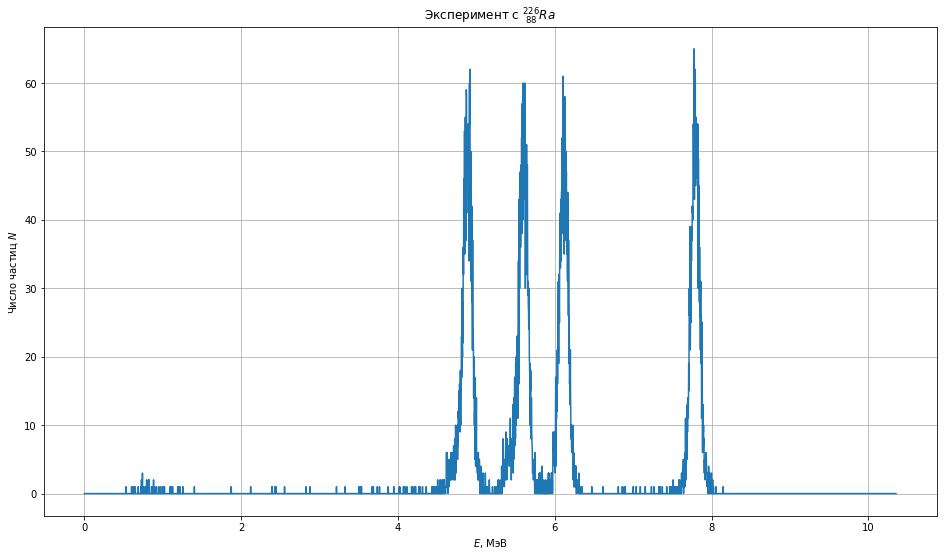

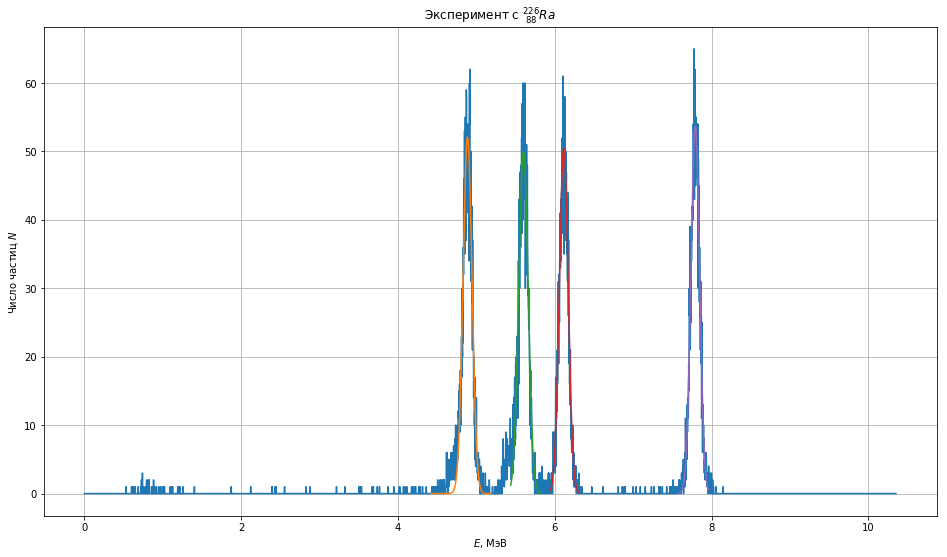

In [19]:
# Сначала пересчитаем в энергию
x_data *= k

# Не забудем пересчитать координаты пиков
for i in range(len(peaks)):
    peaks[i] = (peaks[i][0]*k, peaks[i][1]*k)
    
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

plot_data_optimized(x_values=x_data, y_values=y_data,
                    title=r'Эксперимент с $^{226}_{\,\,88}Ra$', 
                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                    save_to='out1-E.pdf')[0].show()

fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'Эксперимент с $^{226}_{\,\,88}Ra$', 
                                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                                    save_to='out1-E.pdf')
    
fig.show()

Теперь мы готовы идти дальше

### Исследование $^{241}_{\,\,95} Am + ^{230}_{\,\,90} Th$

In [20]:
at_df, at_time = read_table_and_time(
    os.path.join(WORKING_DIRECTORY, AM_TH_FILE))

In [21]:
at_df.head()

19,Channel,Value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [22]:
x_data = at_df['Channel']
y_data = at_df['Value']

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


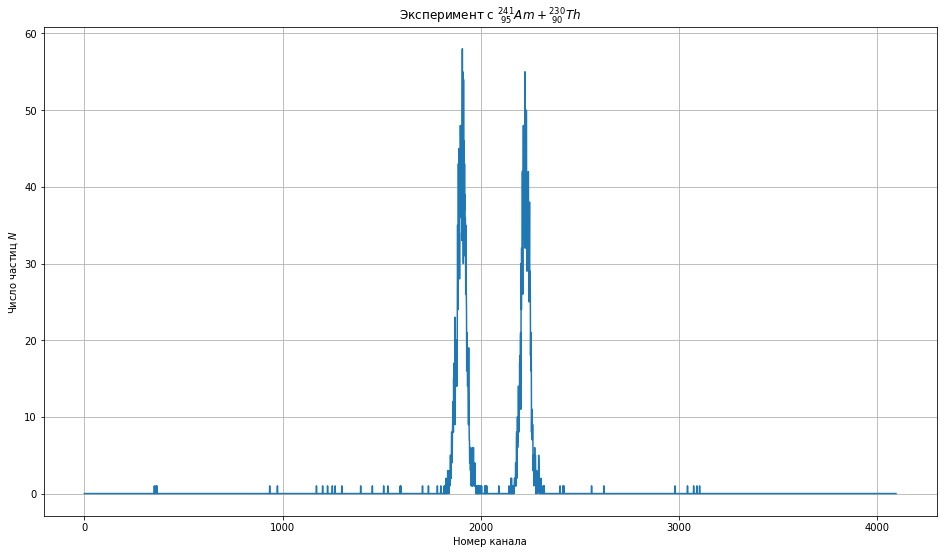

In [23]:
plot_data_optimized(x_values=x_data, y_values=y_data, threshold=0,
                    title=r'Эксперимент с $^{241}_{\,\,95} Am + ^{230}_{\,\,90} Th$', 
                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                    save_to='out2.pdf')[0].show()

Попытаемся аппросимировать пики гауссианой

In [24]:
# TODO: замените на свои
# Я очень хорошо угадал свои интервалы!
peaks = [
    # Большой пик
    (1800, 2000),
    # Большой пик
    (2150, 2300),
]

In [25]:
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

In [26]:
f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


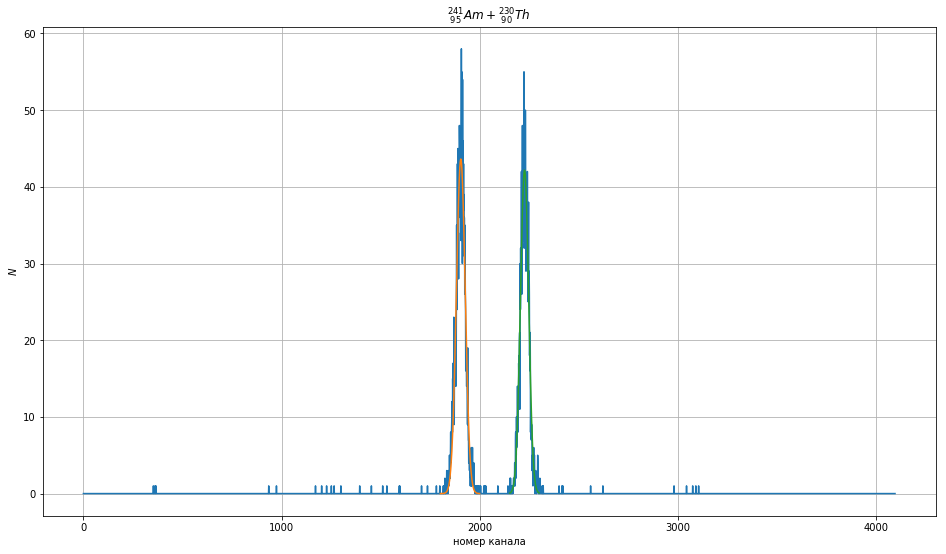

In [27]:
fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'$^{241}_{\,\,95} Am + ^{230}_{\,\,90} Th$', 
                                    x_label=r'номер канала', y_label=r'$N$',
                                    save_to='out2.pdf')
    # Заполним таблицу из лабника
    result_table = pd.concat(
        [result_table, pd.DataFrame([['Am+Th', 
                                      params[i][1], 
                                      get_gauss_halfwidth(params[i][2]), 
                                      # Пока мы их не знаем
                                      0, 0, 0]], columns=res_table_cols)])
fig.show()

Имеем ярко выраженные пики. Подсчитаем их энергию, соглсно п. 1

In [28]:
# Вытащим матожидания
mu = [param[1] for param in params]
E_at = [m*k for m in mu]

In [29]:
E_at

[4.8136595551771935, 5.626788371790571]

\[ \boxed{
    E_1 = 4.795 \text{ МэВ} \\
    E_2 = 5.615 \text{ МэВ} 
}\]

Теперь построим графики $N(E)$, где $E$ пересчитаем по найденному выше $k$

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


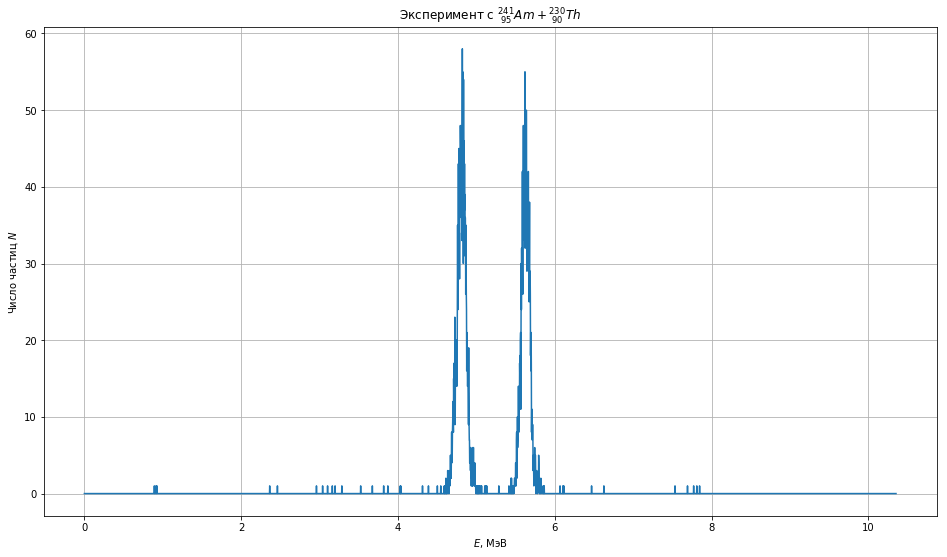

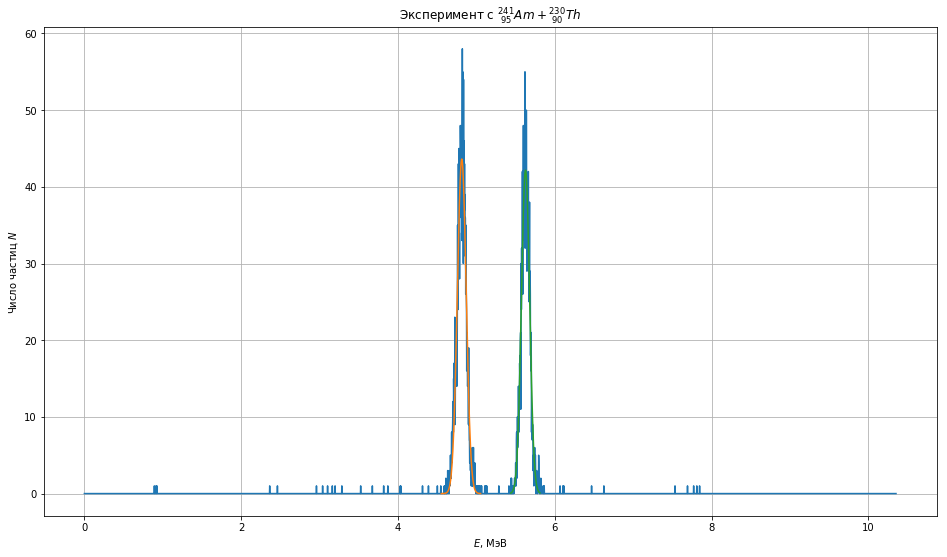

In [30]:
# Сначала пересчитаем в энергию
x_data *= k

# Не забудем пересчитать координаты пиков
for i in range(len(peaks)):
    peaks[i] = (peaks[i][0]*k, peaks[i][1]*k)
    
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

plot_data_optimized(x_values=x_data, y_values=y_data,
                    title=r'Эксперимент с $^{241}_{\,\,95} Am + ^{230}_{\,\,90} Th$', 
                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                    save_to='out2-E.pdf')[0].show()

fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'Эксперимент с $^{241}_{\,\,95} Am + ^{230}_{\,\,90} Th$', 
                                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                                    save_to='out2-E.pdf')
    
fig.show()

### Исследование $^{239}_{\,\,94}Pu$

In [31]:
pu_df, pu_time = read_table_and_time(
    os.path.join(WORKING_DIRECTORY, PU_FILE))

In [32]:
at_df.head()

19,Channel,Value
0,0.000000,0
1,0.002528,0
2,0.005056,0
3,0.007584,0
4,0.010112,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [33]:
x_data = pu_df['Channel']
y_data = pu_df['Value']

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


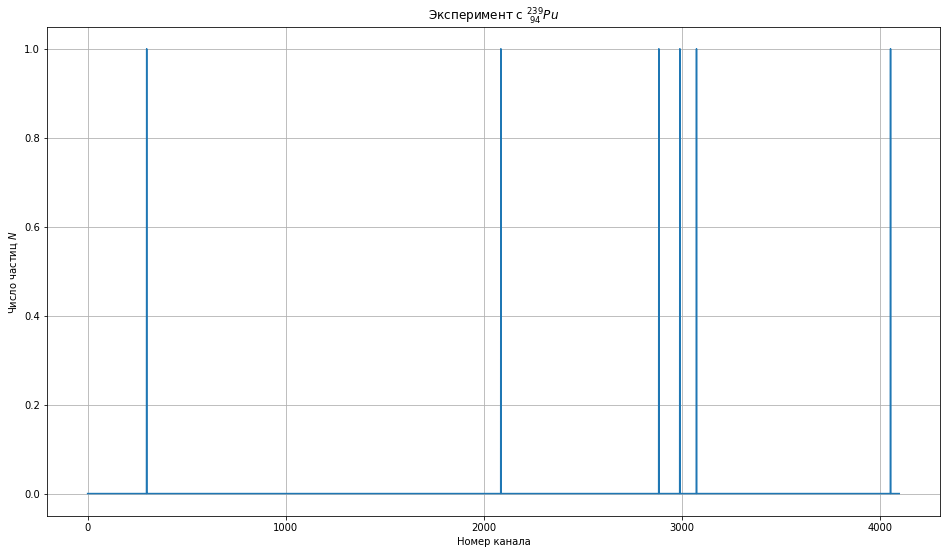

In [34]:
plot_data_optimized(x_values=x_data, y_values=y_data, threshold=0,
                    title=r'Эксперимент с $^{239}_{\,\,94}Pu$', 
                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                    save_to='out3.pdf')[0].show()

Попытаемся аппросимировать пики гауссианой

In [35]:
# TODO: замените на свои
# Я очень хорошо угадал свои интервалы!
peaks = [
    # Большой пик
    (2000, 2200),
]

In [36]:
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

In [37]:
f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


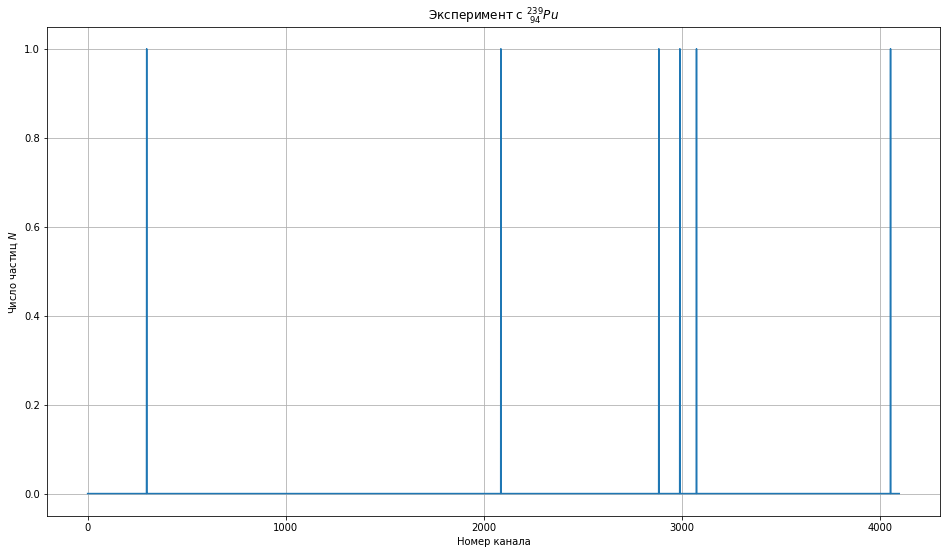

In [38]:
fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'Эксперимент с $^{239}_{\,\,94}Pu$', 
                                    x_label=r'Номер канала', y_label=r'Число частиц $N$',
                                    save_to='out3.pdf')
    # Заполним таблицу из лабника
    result_table = pd.concat(
        [result_table, pd.DataFrame([['Pu', 
                                      params[i][1], 
                                      get_gauss_halfwidth(params[i][2]), 
                                      # Пока мы их не знаем
                                      0, 0, 0]], columns=res_table_cols)])
fig.show()

Имеем ярко выраженный пик. Подсчитаем его энергию, соглсно п. 1

In [39]:
# Вытащим матожидания
mu = [param[1] for param in params]
E_pu = [m*k for m in mu]

In [40]:
E_pu

[81.56390147083452]

\[ \boxed{
    E_1 = 5.298 \text{ МэВ}
}\]

Теперь построим графики $N(E)$, где $E$ пересчитаем по найденному выше $k$

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


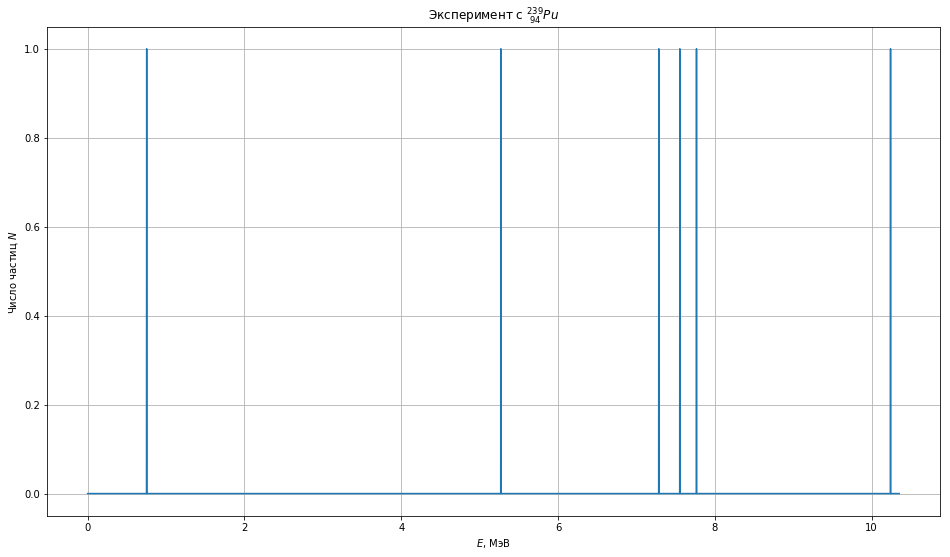

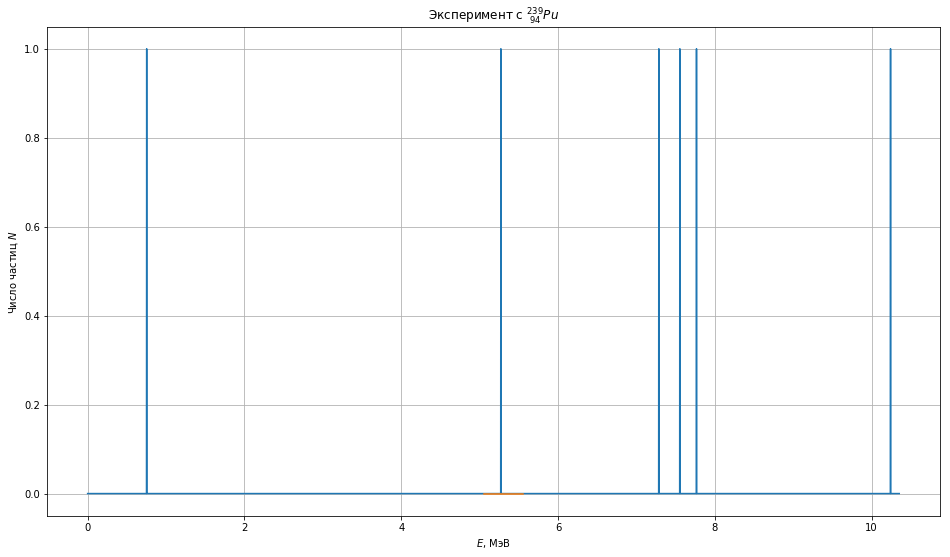

In [41]:
# Сначала пересчитаем в энергию
x_data *= k

# Не забудем пересчитать координаты пиков
for i in range(len(peaks)):
    peaks[i] = (peaks[i][0]*k, peaks[i][1]*k)
    
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

plot_data_optimized(x_values=x_data, y_values=y_data,
                    title=r'Эксперимент с $^{239}_{\,\,94}Pu$', 
                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                    save_to='out3-E.pdf')[0].show()

fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'Эксперимент с $^{239}_{\,\,94}Pu$', 
                                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                                    save_to='out3-E.pdf')
    
fig.show()

### Исследование $U_\text{прир} $

In [42]:
u_df, u_time = read_table_and_time(
    os.path.join(WORKING_DIRECTORY, U_FILE))

In [43]:
u_df.head()

19,Channel,Value
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Построим ориентировочный график зависимости $N(E) = a\,E$

In [44]:
x_data = u_df['Channel']
y_data = u_df['Value']

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


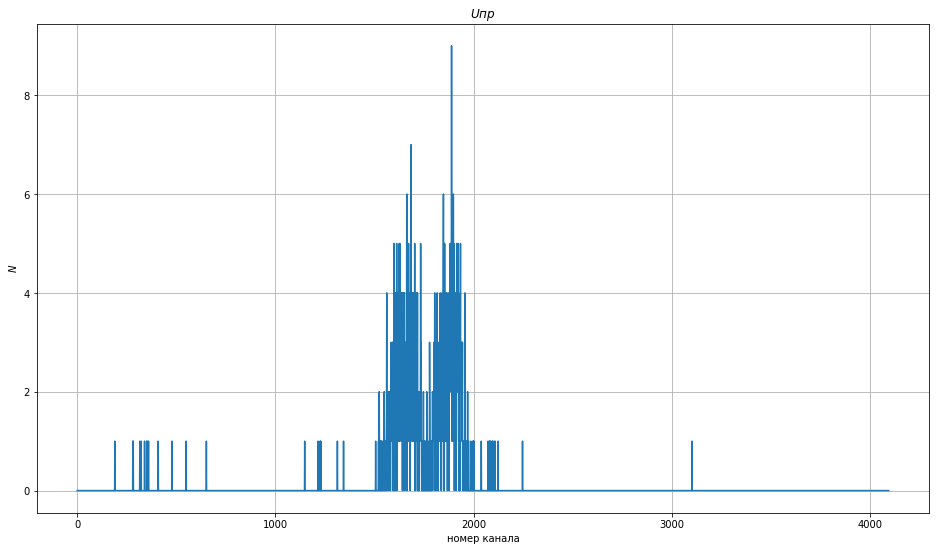

In [45]:
plot_data_optimized(x_values=x_data, y_values=y_data, threshold=0,
                    title=r'$Uпр$', 
                    x_label=r'номер канала', y_label=r'$N$',
                    save_to='out4.pdf')[0].show()

Попытаемся аппросимировать пики гауссианой

In [46]:
# TODO: замените на свои
# Я очень хорошо угадал свои интервалы!
peaks = [
    # Большой пик
    (1500, 1750),
    # Большой пик
    (1770, 2000),
]

In [47]:
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

In [48]:
f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


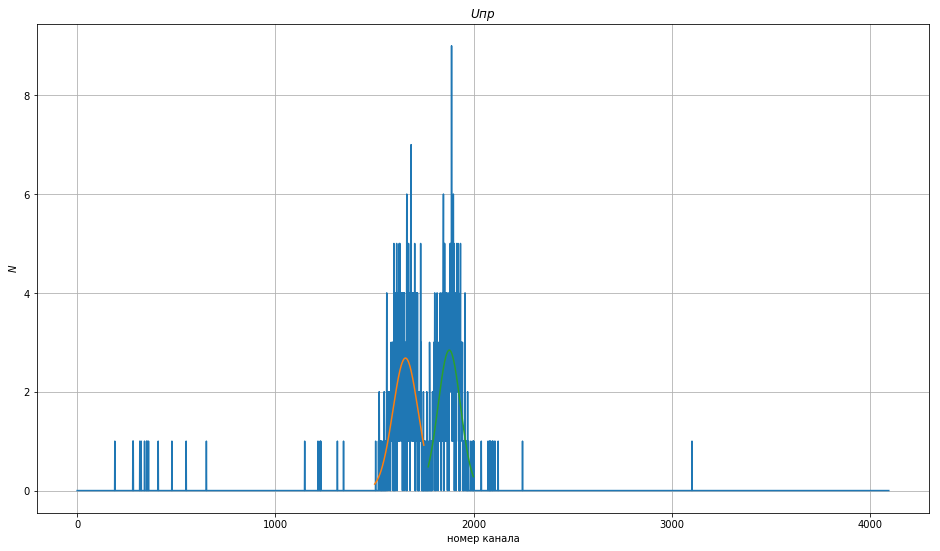

In [49]:
fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'$Uпр$',
                                    x_label=r'номер канала', y_label=r'$N$',
                                    save_to='out4.pdf')
    # Заполним таблицу из лабника
    result_table = pd.concat(
        [result_table, pd.DataFrame([['U', 
                                      params[i][1], 
                                      get_gauss_halfwidth(params[i][2]), 
                                      # Пока мы их не знаем
                                      0, 0, 0]], columns=res_table_cols)])
fig.show()

Имеем плохие пики. Тем не менее, попытаемся подсчитать их энергию:

In [50]:
# Вытащим матожидания
mu = [param[1] for param in params]
E_u = [m*k for m in mu]

In [51]:
E_u

[4.187496753130344, 4.7464444816308005]

\[ \boxed{
    E_1 \approx 4.172 \text{ МэВ} \\
    E_2 \approx 4.739 \text{ МэВ} 
}\]

Теперь построим графики $N(E)$, где $E$ пересчитаем по найденному выше $k$

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


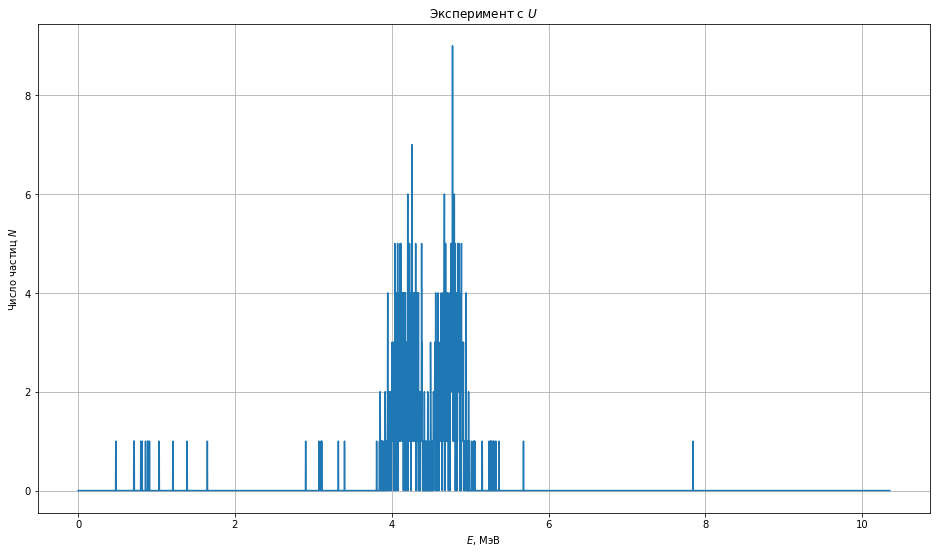

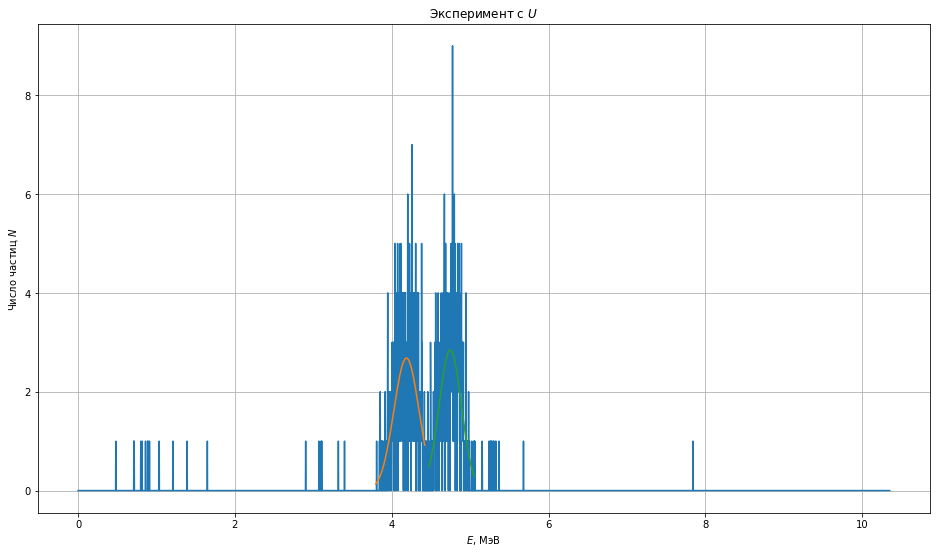

In [52]:
# Сначала пересчитаем в энергию
x_data *= k

# Не забудем пересчитать координаты пиков
for i in range(len(peaks)):
    peaks[i] = (peaks[i][0]*k, peaks[i][1]*k)
    
indices = [(x_data > peak[0]) & (x_data < peak[1]) for peak in peaks]

f, params = [], []
for ind in indices:
    f1, params1 = fit_with_gauss(x_data[ind], y_data[ind], 
                                 initial_guess=[y_data[ind].max(), 0.5, 1])
    f.append(f1)
    params.append(params1)

plot_data_optimized(x_values=x_data, y_values=y_data,
                    title=r'Эксперимент с $U$', 
                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                    save_to='out4-E.pdf')[0].show()

fig, axes = plot_data_optimized(x_data, y_data)
for i in range(len(indices)):
    fig, axes = plot_data_optimized(x_data[indices[i]], 
                                    f[i](x_data[indices[i]]), 
                                    fig=fig, axes=axes,
                                    title=r'Эксперимент с $U$', 
                                    x_label=r'$E$, МэВ', y_label=r'Число частиц $N$',
                                    save_to='out4-E.pdf')
    
fig.show()

## Займемся таблицей из лабника

Вот она

Теперь подсчитаем $E_i$ и $\Delta E_i$, зная значение коэффициента пересчета:

In [53]:
result_table['E_i'] = result_table['N_i']*k
result_table['Delta E_i'] = result_table['Delta N_i']*k
result_table['R_i'] = result_table['Delta E_i'] / result_table['E_i']

In [54]:
result_table

,Источник,N_i,Delta N_i,E_i,Delta E_i,R_i
0,Ra,1932.988894,53.403646,4.886662,0.135006,0.027627
0,Ra,2215.260825,55.432073,5.600255,0.140134,0.025023
0,Ra,2418.818956,52.437278,6.114857,0.132563,0.021679
0,Ra,3082.156351,51.648898,7.791796,0.130570,0.016757
0,Am+Th,1904.111824,52.362397,4.813660,0.132374,0.027500
0,Am+Th,2225.756547,48.743628,5.626788,0.123226,0.021900
0,Pu,32263.766773,8521.525004,81.563901,21.542705,0.264121
0,U,1656.424180,148.911076,4.187497,0.376452,0.089899
0,U,1877.523941,133.083049,4.746444,0.336438,0.070882


Для радия определим $R_\text{фл., i} = \dfrac{1}{\sqrt{N_i}}$, где $N_i = \dfrac{E_i}{E_\text{ср}}$, $E_\text{ср}$ = 3.6 эВ  

In [55]:
R_fluc = 1/np.sqrt(result_table[result_table['Источник'] == 'Ra']['E_i'] / 3.6 * 10**6)

Составим разность $R_i - R_\text{фл., i}$ 

In [56]:
delta_R = result_table[result_table['Источник'] == 'Ra']['R_i'] - R_fluc
ra_R_df = pd.DataFrame(np.array([result_table[result_table['Источник'] == 'Ra']['R_i'].values, 
                        R_fluc.values, delta_R.values]).T, columns=['R_i', 'R_fluc_i', 'Delta R'])

Результаты сведем в таблицу:

In [57]:
ra_R_df

,R_i,R_fluc_i,Delta R
0,0.027627,0.000858,0.026769
1,0.025023,0.000802,0.024221
2,0.021679,0.000767,0.020912
3,0.016757,0.000680,0.016078


## Проверка закона Гейгера-Неттола

Закон Гейгера-Нетолла имеет вид:
$$
\lg T_{1/2} = \dfrac{a}{\sqrt{E_\alpha}} + b
$$

Здесь коэффициенты $a$ и $b$ очень слабо зависят от заряда ядра $Z$

Из материалов к лабораторной работе мы имеем знания об энергии $\alpha$-частиц $^{226}_{\phantom{2} 88} Ra$ и его дочерних ядер, а также их периоды полураспада. По этим данным мы построим график 
$$\lg T_{1/2} = f \left(1 / \sqrt{E_\alpha} \right)$$
Ожидаем прямую!

Перепишем данные из описания к работе:

In [58]:
geiger_netoll_df = pd.DataFrame(np.array([
    [1620*365*24*3600, 3.82*24*3600, 3.11*60, 1.63*10**(-4)], 
    [4.784, 5.490, 6.002, 7.687]]).T, columns=['T', 'E'])

In [59]:
geiger_netoll_df

,T,E
0,5.108832e+10,4.784
1,3.300480e+05,5.490
2,1.866000e+02,6.002
3,1.630000e-04,7.687


Построим требуемый график:

In [60]:
x_data, y_data = 1/np.sqrt(geiger_netoll_df['E']), np.log(geiger_netoll_df['T'])

In [61]:
regression_results = sc.stats.linregress(x_data, y_data)

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


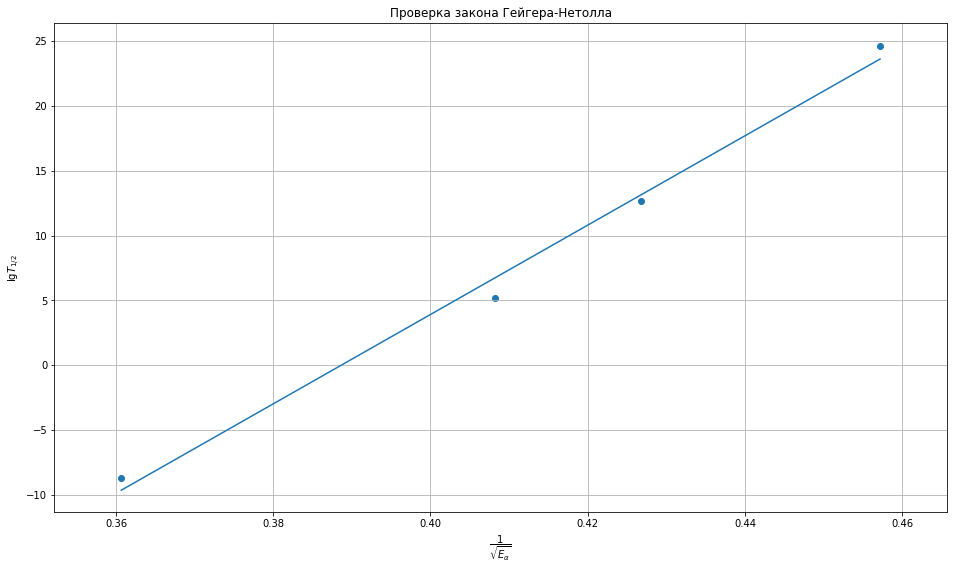

In [62]:
fig, axes = plt.subplots(figsize=(16, 9))
axes.scatter(x_data, y_data)
axes.grid(True)
axes.set_title(r'Проверка закона Гейгера-Нетолла')
axes.set_xlabel(r'$\dfrac{1}{\sqrt{E_\alpha}}$')
axes.set_ylabel(r'$\lg T_{1/2}$')
# Линейная регрессия
x_linreg_data = np.linspace(min(x_data), max(x_data))
f = lambda x: regression_results.slope*x + regression_results.intercept
axes.plot(x_linreg_data, f(x_linreg_data))

fig.savefig('geiger.pdf')
fig.show()

Неплохо выполняется. Линейная регрессия дает значение <b>p-value</b> = {{format(regression_results.pvalue, '.5f')}} и <b>r-value</b> = {{format(regression_results.rvalue, '.5f')}}, что подтвержает гипотезу о линейной зависимости.